# Generic Time-Series Anomaly Detection using Autoencoder

Embedded & TinyML Friendly Student Template

## Objective
This notebook demonstrates a generic anomaly detection approach for time-series sensor data using an autoencoder.

In [89]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import pandas as pd


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

## Configuration (Edit Only This Section)

•	Tensors: Models operate using tensors, essentially lists or arrays of numbers. A 1D tensor is a vector, a 2D tensor is a matrix, and a single number is a scalar.

•	Feature Generation: Raw data, often collected as time series with inconsistent intervals, must be prepared for the model. A common technique is windowing, where a chunk of time is defined, and values within that window are combined (e.g., by averaging) to create a single set of input features.

•	Normalization: For the training algorithm to work effectively, feature values must be scaled, ideally into a similar range (like 0 to 1). For example, 8-bit image data (0-255) is normalized by multiplying values by 1/255.

## Load Sensor Data

In [90]:

normal_df = pd.read_csv("normal_data.csv")
abnormal_df = pd.read_csv("abnormal_data.csv")

print("Normal shape   :", normal_df.shape)
print("Abnormal shape :", abnormal_df.shape)

Normal shape   : (628, 2)
Abnormal shape : (607, 2)


Keeping only [current, vibration] data removing time column

In [ ]:
normal_features = normal_df.drop(columns=['time'])
abnormal_features = abnormal_df.drop(columns=['time'])
#printing shape after dropping the 'time' column
print(normal_features.shape)
print(abnormal_features.shape)


(600, 2)
(600, 2)


Autoencoder is trained ONLY on normal data.

3️⃣ Feature Selection (VERY IMPORTANT)

Keep only numeric sensor features.

In [91]:
features = normal_features.columns.tolist()
print("Features used:", features)


Features used: ['avgIrms', 'avgVib']


Confirming Final Table Data

In [92]:
normal_features.head()

,avgIrms,avgVib
0,0.238878,0.090755
1,0.214502,0.309665
2,0.194047,0.484924
3,0.191660,0.494321
4,0.201750,0.509772


## Sliding Window Creation in not Required here as Anomalies cause instantaneous deviations, not slow wearout

## Normalization and Scalar Selection

This scaler must be reused later on STM32 logic (mean & std).

// Extracted from Python scaler
#define IRMS_MEAN        2.34f
#define IRMS_STD         0.15f
#define VIB_MEAN         0.012f
#define VIB_STD          0.003f

float irms = read_current_sensor();
float vib  = read_vibration_sensor();

// StandardScaler normalization
float irms_norm = (irms - IRMS_MEAN) / IRMS_STD;
float vib_norm  = (vib  - VIB_MEAN)  / VIB_STD;

// Fill AI input buffer
((float*)in_data)[0] = irms_norm;
((float*)in_data)[1] = vib_norm;

In [93]:
scaler = StandardScaler()

X_train = scaler.fit_transform(normal_features)
X_test_normal = scaler.transform(normal_features)
X_test_abnormal = scaler.transform(abnormal_features)

In [94]:
print("Scaler mean :", scaler.mean_)
print("Scaler std  :", scaler.scale_)

Scaler mean : [0.19303803 0.35111946]
Scaler std  : [0.00615908 0.04134532]


## Autoencoder Model

In [96]:
#to Reset the model if trained with same data multiple times to avoid over fitting
tf.keras.backend.clear_session()

In [97]:

N = X_train.shape[1]  # number of features (2)

autoencoder = models.Sequential([
    layers.Dense(8, activation='relu', input_shape=(N,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(N)
])

autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

autoencoder.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

## Training only on Normal Data

In [98]:

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9522 - val_loss: 0.4451
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8718 - val_loss: 0.3878
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7367 - val_loss: 0.3225
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7865 - val_loss: 0.2632
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7723 - val_loss: 0.2055
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6919 - val_loss: 0.1550
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4934 - val_loss: 0.1222
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4297 - val_loss: 0.0990
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4464 - val_loss: 0.0859
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4079 - val_loss: 0.0746
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2963 - val_loss: 0.0642
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2536 - val_lo

## Plot Training Loss

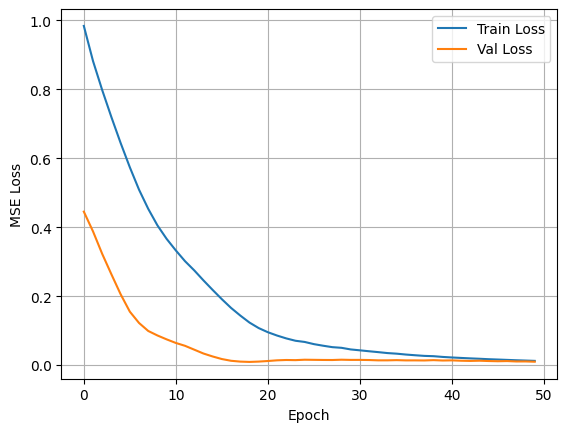

In [99]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()


## Reconstruction Error Function

In [100]:

def reconstruction_error(model, data):
    recon = model.predict(data)
    return np.mean(np.square(data - recon), axis=1)




On STM32, you will compute exactly the same thing:

error = mean((input[i] - output[i])²)


Then:

if (error > THRESHOLD)
    anomaly = 1;
else
    anomaly = 0;

## Compute Errors

In [101]:
err_normal = reconstruction_error(autoencoder, X_test_normal)
err_abnormal = reconstruction_error(autoencoder, X_test_abnormal)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


## Threshold Selection

In [102]:

threshold = np.mean(err_normal) + 3 * np.std(err_normal)
print("Anomaly Threshold:", threshold)


Anomaly Threshold: 0.2892727262753771


## Visualize Error Distribution (Very Important)

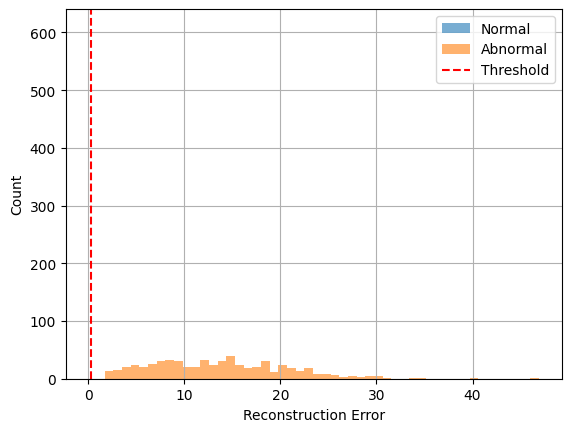

In [103]:
plt.hist(err_normal, bins=50, alpha=0.6, label="Normal")
plt.hist(err_abnormal, bins=50, alpha=0.6, label="Abnormal")
plt.axvline(threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()


## Binary Evaluation

In [104]:
y_true = np.concatenate([
    np.zeros(len(err_normal)),
    np.ones(len(err_abnormal))
])

y_pred = np.concatenate([
    err_normal > threshold,
    err_abnormal > threshold
]).astype(int)


## Confusion Metrics

In [105]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=["Normal", "Anomaly"]
))


Confusion Matrix:
[[627   1]
 [  0 607]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       628
     Anomaly       1.00      1.00      1.00       607

    accuracy                           1.00      1235
   macro avg       1.00      1.00      1.00      1235
weighted avg       1.00      1.00      1.00      1235



## Testing on New Data

In [106]:

sample = abnormal_features.iloc[0].values.reshape(1, -1)
sample_scaled = scaler.transform(sample)

error = reconstruction_error(autoencoder, sample_scaled)[0]

print("Reconstruction Error:", error)

if error > threshold:
    print("⚠️ Anomaly detected")
else:
    print("✅ Normal operation")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Reconstruction Error: 46.92791528220909
⚠️ Anomaly detected


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Convert to TFLITE


In [107]:
autoencoder.save("autoencoder_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("autoencoder_anomaly.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully")
print("Model size:", len(tflite_model), "bytes")


Saved artifact at '/tmp/tmpzf03hm4h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138629035092752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138629011143568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138629011134928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628867858768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628867853584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628867863376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628867853200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138628867853392: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved successfully
Model size: 2748 bytes


Testing on new sensor collected data

In [108]:
#extract data from csv (time column removed data)
new_features = pd.read_csv("1HzData.csv")
#scaling and noramlization same as the one used during training
X_new = scaler.transform(new_features)
#run autoencoder on new data
recon = autoencoder.predict(X_new)
#compute the reconstrction error
err_new = np.mean(np.square(X_new - recon), axis=1)
#Apply the Threshold (Decision Logic)
is_anomaly = err_new > threshold
#Inspect Results (Text Output)
results = new_features.copy()
results['reconstruction_error'] = err_new
results['anomaly'] = is_anomaly

print(results)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
       avgIrms    avgVib  reconstruction_error  anomaly
0     0.238878  0.090755              2.300776     True
1     0.238878  0.090755              2.300776     True
2     0.238878  0.090755              2.300776     True
3     0.214502  0.309665              0.160268    False
4     0.214502  0.309665              0.160268    False
...        ...       ...                   ...      ...
3298  0.219359  0.700977              0.710632     True
3299  0.219359  0.700977              0.710632     True
3300  0.219794  0.741316              0.908171     True
3301  0.219794  0.741316              0.908171     True
3302  0.219794  0.741316              0.908171     True

[3303 rows x 4 columns]


Visualize New Data Errors (Highly Recommended)

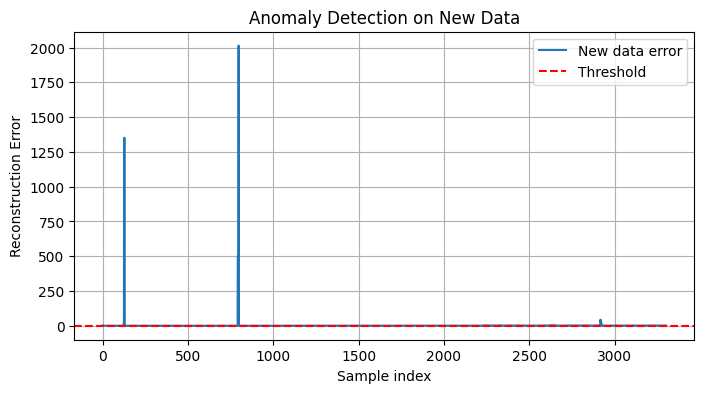

In [109]:
plt.figure(figsize=(8,4))
plt.plot(err_new, label="New data error")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
plt.xlabel("Sample index")
plt.ylabel("Reconstruction Error")
plt.title("Anomaly Detection on New Data")
plt.legend()
plt.grid()
plt.show()


In [110]:
sample = new_features.iloc[0].values.reshape(1, -1)
sample_scaled = scaler.transform(sample)
print(sample_scaled)
recon = autoencoder.predict(sample_scaled)
error = np.mean((sample_scaled - recon) ** 2)

print("Reconstruction error:", error)

if error > threshold:
    print("⚠️ Anomaly detected")
else:
    print("✅ Normal operation")


[[ 7.44271124 -6.29731556]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Reconstruction error: 2.3007741039957175
⚠️ Anomaly detected


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
